# Make a `Toy` Classification data

In [2]:
from sklearn.datasets import make_circles

In [41]:
n_samples = 1000

X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42
)


In [4]:
X[:2], y[:2]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888]]),
 array([1, 1], dtype=int64))

In [5]:
# Make a dataframe of circle data
import pandas as pd

circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "labels": y
})

circles.sample(7)

,X1,X2,labels
463,0.727428,-0.333168,1
596,-0.883656,-0.467756,0
476,0.492955,-0.613424,1
176,-0.976138,-0.090752,0
368,0.137194,-1.034717,0
429,-0.943814,-0.233617,0
559,-0.356614,-0.954756,0


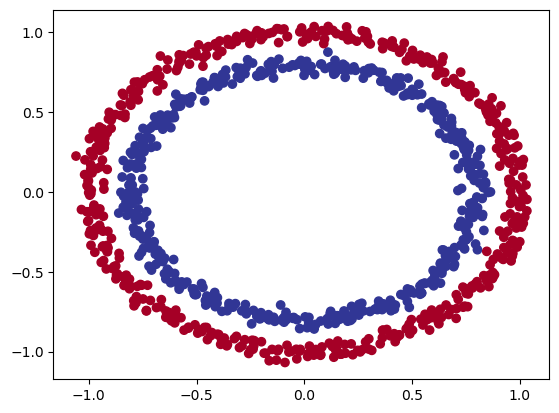

In [6]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(
    x=circles.X1,
    y=circles.X2,
    c=y,
    cmap=plt.cm.RdYlBu
);

In [7]:
# check the shape

X.shape, y.shape

((1000, 2), (1000,))

In [42]:
# Turn data into Tensors
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [43]:
# Splitting into training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
len(X_train), len(X_test), len(y_train), len(y_test)

(750, 250, 750, 250)

# Building a model
* Let's Build a model to Classify our blue and red dots.
    1. Setup device agonistic to run our code on `GPU` if _available_.
    2. Define the Model
        * Subclass `torch.nn.Module`
        * Create 2 `torch.nn.Linear()`
        * Defines a `forward()` function.
        * Instantiate our class and send it to the target `device`
    3. Define a `loss` function and `optimizer`.
    4. Create a Training and a Testing loop.

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
class CircleModelClassifierV0(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = torch.nn.Linear(in_features=2, out_features=5)
        self.layer2 = torch.nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x:torch.tensor) -> torch.tensor:
        return self.layer2(self.layer1(x))
    
model_0 = CircleModelClassifierV0()
model_0.to(device)

CircleModelClassifierV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Replicate the model above useing `torch.nn.Sequential`

model_0 = torch.nn.Sequential(
    torch.nn.Linear(in_features=2, out_features=5),
    torch.nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
dict(model_0.state_dict())

{'0.weight': tensor([[ 0.4876,  0.5468],
         [-0.4383,  0.0963],
         [ 0.7000, -0.6217],
         [ 0.2589,  0.0807],
         [ 0.5814, -0.1869]]),
 '0.bias': tensor([ 0.3094, -0.1746,  0.3631, -0.0980,  0.0261]),
 '1.weight': tensor([[-0.2833, -0.0175, -0.2986, -0.1393,  0.0390]]),
 '1.bias': tensor([0.1877])}

In [16]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [17]:
with torch.inference_mode():
    untrained_preds = model_0(X_test)
    
untrained_preds[:5]

tensor([[ 0.1489],
        [ 0.0140],
        [ 0.2540],
        [ 0.1202],
        [-0.1405]])

In [18]:
# Set up loss function and optimizer.

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [19]:
# define accuracy function

def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

# Train Model
To train our model, we need to follow these steps:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss Backward (backpropagation)
5. Optimizer step (gradient descent)

Going from raw logits -> prediction probabilities -> prediction labels.

* **In Details:** We will Convert these `logits` into `prediction probabilities` by passing them to an `activation function`, Then we can convert the `prediction probabilities` to `prediction labels` by taking the `torch.argmax()`

In [20]:
# First 5 outputs of the forward pass on the test data.
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
    
y_logits, y_test[:5]

(tensor([[ 0.1489],
         [ 0.0140],
         [ 0.2540],
         [ 0.1202],
         [-0.1405]]),
 tensor([1., 0., 1., 0., 1.]))

In [21]:
# Use the sigmoid activation function to get the prediction probabilities.
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5372],
        [0.5035],
        [0.5632],
        [0.5300],
        [0.4649]])

In [22]:
# Now from prediction probabilities to prediction labels.
y_pred_labels = torch.argmax(y_pred_probs, dim=1)
y_pred_labels

tensor([0, 0, 0, 0, 0])

In [23]:
torch.manual_seed(42)

epochs = 200
for epoch in range(epochs):
    
    model_0.train() # -> Training
    
    y_logits = model_0(X_train).squeeze() # -> Forward pass
    y_preds = torch.round(torch.sigmoid(y_logits)) 
    
    train_loss = loss_fn(y_logits, y_train) # -> Calculate the loss
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    
    optimizer.zero_grad() # -> zero grad
    train_loss.backward() # -> backpropagation
    optimizer.step # -> gradient descent
    
    model_0.eval()  # -> Evaluating
    
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f},  Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69999,  Acc: 50.00% | Test Loss: 0.69771, Test acc: 50.00%
Epoch: 10 | Loss: 0.69999,  Acc: 50.00% | Test Loss: 0.69771, Test acc: 50.00%
Epoch: 20 | Loss: 0.69999,  Acc: 50.00% | Test Loss: 0.69771, Test acc: 50.00%
Epoch: 30 | Loss: 0.69999,  Acc: 50.00% | Test Loss: 0.69771, Test acc: 50.00%
Epoch: 40 | Loss: 0.69999,  Acc: 50.00% | Test Loss: 0.69771, Test acc: 50.00%
Epoch: 50 | Loss: 0.69999,  Acc: 50.00% | Test Loss: 0.69771, Test acc: 50.00%
Epoch: 60 | Loss: 0.69999,  Acc: 50.00% | Test Loss: 0.69771, Test acc: 50.00%
Epoch: 70 | Loss: 0.69999,  Acc: 50.00% | Test Loss: 0.69771, Test acc: 50.00%
Epoch: 80 | Loss: 0.69999,  Acc: 50.00% | Test Loss: 0.69771, Test acc: 50.00%
Epoch: 90 | Loss: 0.69999,  Acc: 50.00% | Test Loss: 0.69771, Test acc: 50.00%
Epoch: 100 | Loss: 0.69999,  Acc: 50.00% | Test Loss: 0.69771, Test acc: 50.00%
Epoch: 110 | Loss: 0.69999,  Acc: 50.00% | Test Loss: 0.69771, Test acc: 50.00%
Epoch: 120 | Loss: 0.69999,  Acc: 50.00% | Test Los

# Make predictions and evaluate the model

In [24]:
type(model_0)

torch.nn.modules.container.Sequential

In [25]:
import requests
from pathlib import Path

TARGET_URL = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
FILE_NAME = TARGET_URL.split("/")[-1]

if Path("helper_functions.py").is_file():
    print("The file already exist")
    
else:
    
    response = requests.get(TARGET_URL)
    with open(FILE_NAME, "wb") as f:
        f.write(response.content)
        
    print(f"{FILE_NAME} downloaded successfully.")

The file already exist


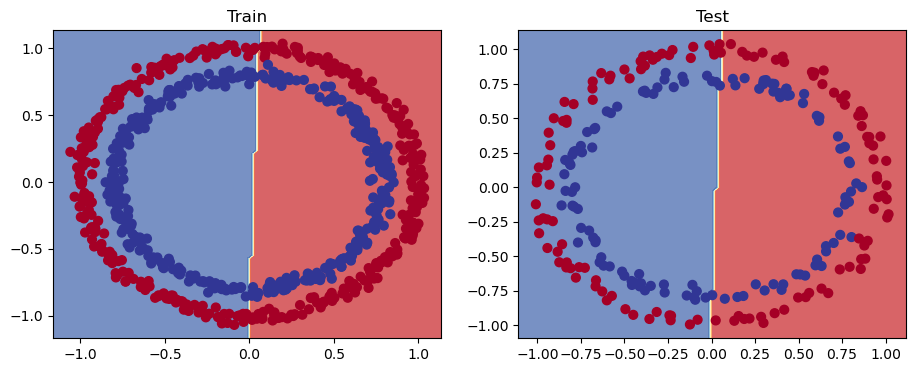

In [26]:
# Plot decision boundry of the model.
from helper_functions import plot_decision_boundary, plot_predictions

plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


# Improving our Model
* Add more Layers
* Add more hidden units
* Fit for Longer
* Changing the activation function
* Change the Learning Rate
* Change the loss function

In [27]:
class CircleModelClassifierV1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = torch.nn.Linear(in_features=2, out_features=10)
        self.layer2 = torch.nn.Linear(in_features=10, out_features=10)
        self.layer3 = torch.nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))
    
model_1 = CircleModelClassifierV1()
model_1.to(device)

CircleModelClassifierV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [29]:
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    
    model_1.train()
    
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_1.eval()
    with torch.inference_mode():
        y_test_logits = model_1(X_test).squeeze()
        y_test_preds = torch.round(torch.sigmoid(y_test_logits))

        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_preds)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Acc: {acc:.2f}%, Loss: {loss:.5f} | Test Acc: {test_acc:.2f}%, Test Loss: {test_loss:.5f}")
        

Epoch: 0 | Acc: 51.07%, Loss: 0.69377 | Test Acc: 50.00%, Test Loss: 0.69343
Epoch: 100 | Acc: 54.80%, Loss: 0.69298 | Test Acc: 50.40%, Test Loss: 0.69412
Epoch: 200 | Acc: 53.20%, Loss: 0.69292 | Test Acc: 48.40%, Test Loss: 0.69455
Epoch: 300 | Acc: 52.40%, Loss: 0.69292 | Test Acc: 48.80%, Test Loss: 0.69471
Epoch: 400 | Acc: 52.53%, Loss: 0.69292 | Test Acc: 49.20%, Test Loss: 0.69477
Epoch: 500 | Acc: 52.53%, Loss: 0.69292 | Test Acc: 49.60%, Test Loss: 0.69479
Epoch: 600 | Acc: 52.53%, Loss: 0.69292 | Test Acc: 49.60%, Test Loss: 0.69480
Epoch: 700 | Acc: 52.53%, Loss: 0.69292 | Test Acc: 49.60%, Test Loss: 0.69480
Epoch: 800 | Acc: 52.67%, Loss: 0.69292 | Test Acc: 49.60%, Test Loss: 0.69480
Epoch: 900 | Acc: 52.67%, Loss: 0.69292 | Test Acc: 49.60%, Test Loss: 0.69480


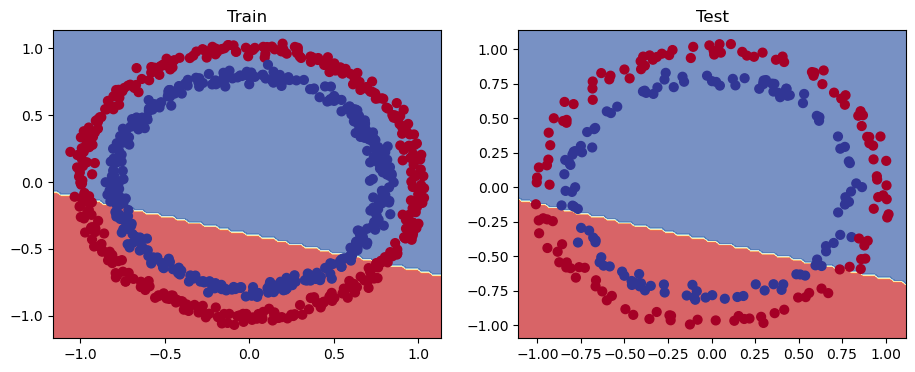

In [30]:

plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Silly me 😅, How can i use a simple `linear regression` formula to classify between **Two overlapping circles** like this.
### Hmmm, I should add some non-linearity to the model. 🤔

# Building a model with non-Linearity

In [49]:
import torch

class CircleModelClassifierV2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = torch.nn.Linear(in_features=2, out_features=64)
        self.layer2 = torch.nn.Linear(in_features=64, out_features=32)
        self.layer3 = torch.nn.Linear(in_features=32, out_features=1)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

    
model_3 = CircleModelClassifierV2()
model_3.to(device)

CircleModelClassifierV2(
  (layer1): Linear(in_features=2, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [50]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [51]:
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    
    model_3.train()
    
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred=y_preds, y_true=y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_3.eval()
    
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_pred=test_preds, y_true=y_test)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Acc: {acc:.2f}%, Loss: {loss:.5f} | Test Acc: {test_acc:.2f}%, Test Loss: {test_loss:.5f}")

Epoch: 0 | Acc: 49.47%, Loss: 0.69341 | Test Acc: 51.60%, Test Loss: 0.69039
Epoch: 100 | Acc: 68.27%, Loss: 0.68111 | Test Acc: 59.60%, Test Loss: 0.68366
Epoch: 200 | Acc: 74.67%, Loss: 0.66216 | Test Acc: 69.20%, Test Loss: 0.66863
Epoch: 300 | Acc: 89.20%, Loss: 0.62270 | Test Acc: 84.80%, Test Loss: 0.63390
Epoch: 400 | Acc: 98.40%, Loss: 0.53111 | Test Acc: 97.60%, Test Loss: 0.55198
Epoch: 500 | Acc: 99.87%, Loss: 0.36637 | Test Acc: 98.80%, Test Loss: 0.40068
Epoch: 600 | Acc: 99.87%, Loss: 0.20187 | Test Acc: 98.80%, Test Loss: 0.23889
Epoch: 700 | Acc: 100.00%, Loss: 0.12088 | Test Acc: 100.00%, Test Loss: 0.15334
Epoch: 800 | Acc: 100.00%, Loss: 0.07216 | Test Acc: 100.00%, Test Loss: 0.09943
Epoch: 900 | Acc: 100.00%, Loss: 0.04874 | Test Acc: 100.00%, Test Loss: 0.07229


# Model Evaluation & Plot Predictions

In [52]:
model_3.eval()

with torch.inference_mode():
    predictions = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
    
    
y_test[:5], predictions[:5]

(tensor([1., 0., 1., 0., 1.]), tensor([1., 0., 1., 0., 1.]))

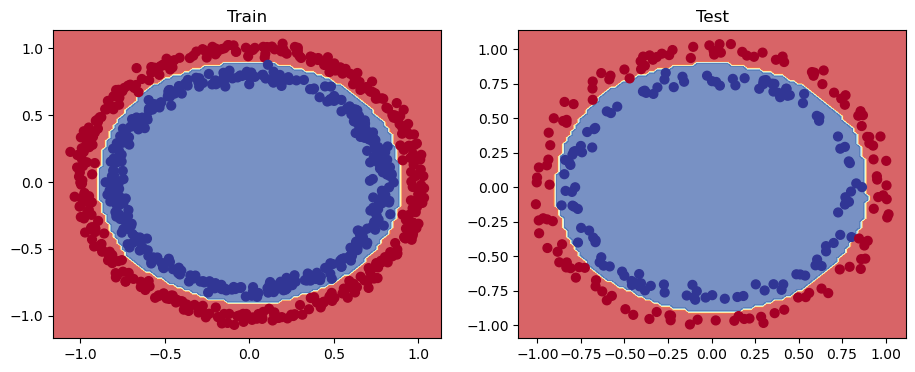

In [53]:
# plot some results

plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

# Putting all together
#### Multiclass Classification problem

## Creating a Toy multiclass classsification

In [54]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


In [102]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

x_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_SEED
)

In [103]:
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_train_blob, X_test_blob, y_train_blob, y_test_blob = train_test_split(
    x_blob,
    y_blob,
    test_size=0.25,
    random_state=RANDOM_SEED

)

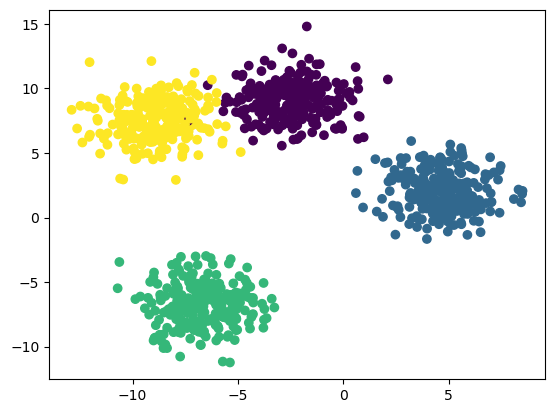

In [104]:
plt.scatter(x=x_blob[:, 0], y=x_blob[:, 1], c=y_blob)


## Creating a Multi-class classification Model

In [105]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [125]:
class BlobModelClassifier(torch.nn.Module):
    def __init__(self, in_features, out_features, hidden_units=8):
        super().__init__()
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(in_features=in_features, out_features=hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_units, out_features=hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_units, out_features=out_features),   
        )
        
    def forward(self, x):
        return self.model(x)
    
model_4 = BlobModelClassifier(in_features=2, out_features=NUM_CLASSES).to(device)
model_4

BlobModelClassifier(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Loss Function and Optimizer
**Remember That**: Going from raw logits -> prediction probabilities -> prediction labels.
* in this case `multi-class` we will use `softmax` instead of `sigmoid` to get _prediction probabilities_ from _logits_

In [126]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [127]:
model_4.eval()

with torch.inference_mode():
    y_logits = model_4(X_test_blob)
    
y_logits[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])

In [128]:
y_labels = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
y_labels[:5], y_test_blob[:5]

(tensor([1, 0, 0, 0, 0]), tensor([1, 3, 2, 1, 0]))

## Train the model

In [129]:
torch.manual_seed(42)

X_train_blob = X_train_blob.to(device)
X_test_blob = X_test_blob.to(device)
y_train_blob = y_train_blob.to(device)
y_test_blob = y_test_blob.to(device)

epochs = 100

for epoch in range(epochs):
    
    model_4.train()
    
    y_logits = model_4(X_train_blob)
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    
    loss = loss_fn(y_logits, y_train_blob)
    acc = accuracy_fn(y_pred=y_preds, y_true=y_train_blob)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_4.eval()
    
    with torch.inference_mode():
        test_logits = model_4(X_test_blob)
        test_preds = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
        
        test_loss = loss_fn(test_logits, y_test_blob)
        test_acc = accuracy_fn(y_pred=test_preds, y_true=y_test_blob)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Acc: {acc:.2f}%, Loss: {loss:.5f} | Test Acc: {test_acc:.2f}%, Test Loss: {test_loss:.5f}")

Epoch: 0 | Acc: 39.47%, Loss: 1.16018 | Test Acc: 53.20%, Test Loss: 1.06842
Epoch: 10 | Acc: 96.93%, Loss: 0.64578 | Test Acc: 97.20%, Test Loss: 0.64848
Epoch: 20 | Acc: 98.53%, Loss: 0.42565 | Test Acc: 100.00%, Test Loss: 0.42144
Epoch: 30 | Acc: 99.07%, Loss: 0.25143 | Test Acc: 99.60%, Test Loss: 0.23646
Epoch: 40 | Acc: 99.20%, Loss: 0.11139 | Test Acc: 99.60%, Test Loss: 0.09790
Epoch: 50 | Acc: 99.20%, Loss: 0.06667 | Test Acc: 99.60%, Test Loss: 0.05642
Epoch: 60 | Acc: 99.20%, Loss: 0.05136 | Test Acc: 99.60%, Test Loss: 0.04138
Epoch: 70 | Acc: 99.20%, Loss: 0.04381 | Test Acc: 99.60%, Test Loss: 0.03349
Epoch: 80 | Acc: 99.20%, Loss: 0.03920 | Test Acc: 99.60%, Test Loss: 0.02862
Epoch: 90 | Acc: 99.20%, Loss: 0.03618 | Test Acc: 99.60%, Test Loss: 0.02541


## Make a predictions

In [130]:
model_4.eval()
# Make a predictions
with torch.inference_mode():
    y_logits = model_4(X_test_blob)
    
# go from logits to probabilities
y_preds = torch.softmax(y_logits, dim=1)

# The last step from predictions to labels
y_labels = torch.argmax(y_preds, dim=1)


In [131]:
y_labels[:7], y_test_blob[:7]

(tensor([1, 3, 2, 1, 0, 3, 2]), tensor([1, 3, 2, 1, 0, 3, 2]))

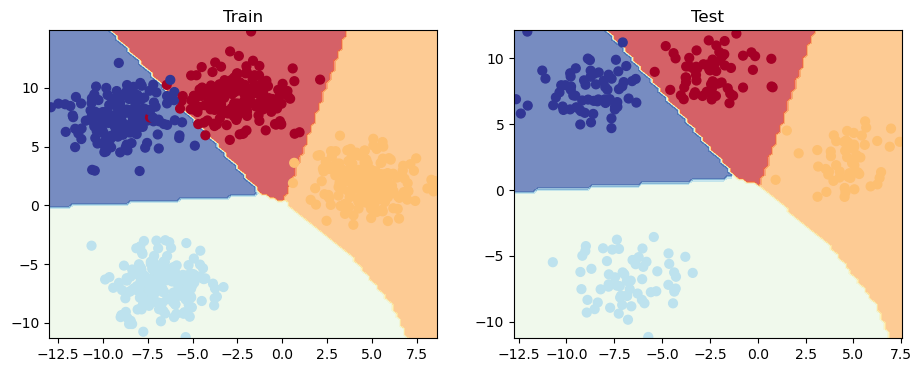

In [132]:
# plot some results

plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train_blob, y_train_blob)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test_blob, y_test_blob)

# Classification Metrics
* Accuracy
* Precision
* Recall
* F1-score
* Confusion matrix
* Calssification report

In [139]:
from torchmetrics import Accuracy

accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

accuracy(y_test_blob, y_labels)

tensor(0.9960)